In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
import pandas as pd
from matplotlib import pyplot
from keras.layers import Input, Dense, BatchNormalization, Lambda, GaussianNoise, GaussianDropout
from keras.models import Model
import keras.backend as backend
import numpy as np
import keras
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import np_utils
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
import math
from sklearn.metrics import mean_squared_error,median_absolute_error,mean_absolute_error,explained_variance_score,r2_score
from math import sqrt
import keras.utils as np_utils
from sklearn.preprocessing import LabelEncoder
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = "1uiIMbheUVJK82LMshquFhDAQW8vAE6Dt"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('gene.trainset.csv')  
gene_1 = pd.read_csv('gene.trainset.csv')

In [4]:
gene_train = gene_1.drop(columns = ["Cancer_Type", "Sample_ID"])

In [5]:
id = "1MCvPmLzJnMq-DM9ch0MS7B3btv7RN3QO"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('gene.val.csv')  
gene_2 = pd.read_csv('gene.val.csv')

In [6]:
gene_test = gene_2.drop(columns = ["Cancer_Type", "Sample_ID"])

In [7]:
id = '1ZhpxOI75zZBBJMRu4supVZzWzGmoFUaR'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('pro.trainset.csv')  
pro1 = pd.read_csv('pro.trainset.csv')

In [8]:
lable_train = list(pro1.Cancer_Type)
pro_train = pro1.drop(columns = ["Cancer_Type", "Sample_ID"])

In [9]:
id = '1Mof6HE8iPsGB5-ZzXvE8pulizup1EVjM'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('pro.val.csv')  
pro2 = pd.read_csv('pro.val.csv')

In [10]:
lable_test = list(pro2.Cancer_Type)
pro_test = pro2.drop(columns = ["Cancer_Type", "Sample_ID"])

In [11]:
le = LabelEncoder()
lable1 = np.ravel(lable_train)
le.fit(lable1)
lable1 = le.transform(lable1)

le = LabelEncoder()
lable2 = np.ravel(lable_test)
le.fit(lable2)
lable2 = le.transform(lable2)


In [12]:
cat1 = np_utils.to_categorical(lable1)
cat1 = pd.DataFrame({'tag' + str(i) : cat1[:, i]for i in range(len(cat1[0]))})
cat_train = cat1[:gene_train.shape[0]]

cat2 = np_utils.to_categorical(lable2)
cat2 = pd.DataFrame({'tag' + str(i) : cat2[:, i]for i in range(len(cat2[0]))})
cat_test = cat2[:gene_test.shape[0]]

In [23]:
def model(m_rna_train, pro_train,label_train, m_rna_test, pro_test, label_test):
        """
        We conducted an architecture of Contractive Autoencoder that is capable of simultaneous inference of various properties of biological samples, 
        through multi-task and transfer learning. It encodes the whole transcription profile into a strikingly low-dimensional latent vector of size 8, and then 
        recovers mRNA and protein expression profiles, disease type from this vector. This latent space is significantly better than the original gene 
        expression profiles for discriminating samples based on their disease. 
        We employed this architecture on mRNA transcription profiles of 7150 clinical samples from 32 classes.
        :param : m_rna_train, pro_train,label_train, m_rna_test, pro_test, label_test
        :return: pred_train, pred_pro, score, history
        """
        opt = keras.optimizers.Nadam(learning_rate=1e-3)

        inputs = Input(shape=(m_rna_train.shape[1],), name="inputs")

        # Q(z|x) -- encoder
        inputs_noise = GaussianNoise(stddev=0.0)(inputs)
        drop1 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_noise)
        inputs_0 = BatchNormalization(name="inputs_0")(drop1)
        inputs_1 = Dense(1024, activation='relu', name="inputs_1")(inputs_0)
        inputs_2 = BatchNormalization(name="inputs_2")(inputs_1)
        drop2 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_2)
        inputs_3 = Dense(512, activation='relu', name="inputs_3")(drop2)
        inputs_4 = BatchNormalization(name="inputs_4")(inputs_3)
        drop3 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_4)
        inputs_5 = Dense(128, activation='relu', name="inputs_5")(inputs_4)
        inputs_6= BatchNormalization(name="inputs_6")(inputs_5)
        drop4 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_6)
        latent = Dense(8, activation='linear', name="encoded")(drop4)

        # Decoder of Gene Expression Profile
        inputs_7 = BatchNormalization(name="inputs_7")(latent)
        inputs_8 = Dense(128, activation='relu', name="inputs_8")(inputs_7)
        inputs_9 = BatchNormalization(name="inputs_9")(inputs_8)
        drop5 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_9)
        inputs_11 = Dense(512, activation='relu', name="inputs_11")(drop5)
        inputs_12 = BatchNormalization(name="inputs_12")(inputs_11)
        drop6 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_12)
        inputs_14 = Dense(1024, activation='relu', name="inputs_14")(drop6)
        inputs_15 = BatchNormalization(name="inputs_15")(inputs_14)
        drop7 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_15)
        output_tcga = Dense(m_rna_train.shape[1], activation='relu', name="m_rna")(drop7)

        # Decoder of Protein Expression Profile
        inputs_16 = BatchNormalization(name="inputs_16")(latent)
        inputs_17 = Dense(64, activation='relu', name="inputs_17")(inputs_16)
        inputs_18 = BatchNormalization(name="inputs_18")(inputs_17)
        drop8 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_18)
        inputs_19 = Dense(128, activation='relu', name="inputs_19")(drop8)
        inputs_20 = BatchNormalization(name="inputs_20")(inputs_19)
        drop9 = GaussianDropout(rate=0.5 ** 2 / (1 + 0.5 ** 2))(inputs_20)
        output_pro = Dense(pro_train.shape[1], activation='relu', name="pro")(drop9)

        # Classifier
        output_cl_0 = Dense(32, activation="softmax", name="cl_cancer")(latent)


        lambda_value = 2.5596e-6

        def contractive_loss(y_pred, y_true):

            w = backend.variable(value=scae.get_layer('encoded').get_weights()[0])  
            w = backend.transpose(w)  
            h = scae.get_layer('encoded').output
            dh = h * (1 - h)  
            contractive = lambda_value * backend.sum(dh ** 2 * backend.sum(w ** 2, axis=1), axis=1)
            mse = backend.mean(backend.square(y_true - y_pred), axis=1)
            return mse + contractive

        scae = Model(inputs, [output_tcga, output_pro, output_cl_0])

        scae.compile(optimizer='nadam',
                     loss=[contractive_loss, "mse", "categorical_crossentropy"],
                     loss_weights=[5e-2, 5e-2, 5e-1],
                     metrics={"m_rna":[contractive_loss, "mse", "mae"], "pro": ["mae", "mse"], "cl_cancer": "acc"})
        
        
        history = scae.fit([m_rna_train], [m_rna_train, pro_train, label_train],
                 batch_size=24, epochs=10, verbose=1, validation_data = (m_rna_test, [m_rna_test, pro_test, label_test]))
        score = scae.evaluate(m_rna_test, [m_rna_test, pro_test, label_test], verbose=1,
                              batch_size=24)
        pred_pro = scae.predict(m_rna_test, verbose=1,
                              batch_size=24)
        pred_train = scae.predict(m_rna_train, verbose=1,
                              batch_size=24)
        return pred_train, pred_pro, score, history

In [24]:
train_y = pro_train.to_numpy()
test_y = pro_test.to_numpy()
label_train = np.array(cat_train)
label_test = np.array(cat_test)

train_x_log = np.log2(gene_train)
train_x_log1 = train_x_log.replace(to_replace = np.nan, value =0.00)
train_x_log2 = train_x_log1.replace(to_replace =-math.inf, value =0.0000)
arr = []
for i in np.arange(train_x_log2.shape[1]):
  idx = (train_x_log2.iloc[:,i]==0.0)
  arr.append(len(train_x_log2.iloc[:,i][idx]))
arr_idx = []
for i in np.arange(train_x_log2.shape[1]):
  if arr[i] <= 3000:
    arr_idx.append(train_x_log2.columns[i])
train_x_log3 = train_x_log2[arr_idx][:][:-2]
val_x_log = np.log2(gene_test)
val_x_log1 = val_x_log.replace(to_replace =-math.inf, value =0.0000)
val_x_log2 = val_x_log1.replace(to_replace = np.nan, value =0.00)
val_x_log3 = val_x_log2[arr_idx]
val_x_log3 = val_x_log3[:][:-1]
test_y = test_y[:-1][:]
train_y = train_y[:-2][:]
label_test = label_test[:-1][:]
label_train = label_train[:-2][:]
pred_train, pred_pro, score, history = model(train_x_log3, train_y, label_train, val_x_log3, test_y, label_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


Train on 5736 samples, validate on 672 samples
Epoch 1/10
5736/5736 [==============================] - ETA: 0s - loss: 0.7822 - m_rna_loss: 6.8533 - pro_loss: 0.5205 - cl_cancer_loss: 0.8270 - m_rna_contractive_loss: 6.8533 - m_rna_mean_squared_error: 6.8070 - m_rna_mean_absolute_error: 1.8212 - pro_mean_absolute_error: 0.4919 - pro_mean_squared_error: 0.5205 - cl_cancer_acc: 0.8159

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


5736/5736 [==============================] - 168s 29ms/sample - loss: 0.7822 - m_rna_loss: 6.8533 - pro_loss: 0.5205 - cl_cancer_loss: 0.8270 - m_rna_contractive_loss: 6.8533 - m_rna_mean_squared_error: 6.8070 - m_rna_mean_absolute_error: 1.8212 - pro_mean_absolute_error: 0.4919 - pro_mean_squared_error: 0.5205 - cl_cancer_acc: 0.8159 - val_loss: 0.5036 - val_m_rna_loss: 6.2460 - val_pro_loss: 0.3987 - val_cl_cancer_loss: 0.3427 - val_m_rna_contractive_loss: 6.2460 - val_m_rna_mean_squared_error: 5.9202 - val_m_rna_mean_absolute_error: 1.6255 - val_pro_mean_absolute_error: 0.4170 - val_pro_mean_squared_error: 0.3987 - val_cl_cancer_acc: 0.9286
Epoch 2/10
5736/5736 [==============================] - 157s 27ms/sample - loss: 0.4641 - m_rna_loss: 5.7903 - pro_loss: 0.4079 - cl_cancer_loss: 0.3083 - m_rna_contractive_loss: 5.7903 - m_rna_mean_squared_error: 5.6922 - m_rna_mean_absolute_error: 1.5639 - pro_mean_absolute_error: 0.4268 - pro_mean_squared_error: 0.4079 - cl_cancer_acc: 0.9224 

In [25]:
def GetAverageRank(test, predict):
    p = predict
    rank  = 0
    for k in range(len(p)):
        temp = np.vstack((test, p[k]))
        for i in range(temp.shape[0]):
            temp[i] = np.subtract(temp[i], test[k])
        temp = np.square(temp)
        sum = temp.sum(axis = 1)
        arr = []
        for i in range(len(sum)):
            arr.append((sum[i], i))
        arr = sorted(arr, key=lambda x: x[0])
        for i in range(len(arr)):
            if arr[i][1] == len(p):
                rank += i
                break
    rank /= len(p)
    return rank

print(GetAverageRank(test_y,pred_pro[1]))

13.302083333333334


In [26]:
print("Eval Metrics for Test Set")
print("explained_variance_score", explained_variance_score(test_y, pred_pro[1]))
print("median_absolute_error", median_absolute_error(test_y, pred_pro[1]))
print("r2_score", r2_score(test_y, pred_pro[1]))
print("RMSE", sqrt(mean_squared_error(test_y, pred_pro[1])))
print("mean_absolute_error", mean_absolute_error(test_y, pred_pro[1]))
print("mean_squared_error", mean_squared_error(test_y, pred_pro[1]))

Eval Metrics for Test Set
explained_variance_score 0.2045691415092944
median_absolute_error 0.3157692093854685
r2_score 0.14237414276367616
RMSE 0.592986133741898
mean_absolute_error 0.3923536679655552
mean_squared_error 0.3516325548101642


In [27]:
print("Eval Metrics for Train Set")
print("explained_variance_score", explained_variance_score(train_y,pred_train[1]))
print("median_absolute_error", median_absolute_error(train_y,pred_train[1]))
print("r2_score", r2_score(train_y,pred_train[1]))
print("RMSE", sqrt(mean_squared_error(train_y,pred_train[1])))
print("mean_absolute_error", mean_absolute_error(train_y,pred_train[1]))
print("mean_squared_error", mean_squared_error(train_y,pred_train[1]))

Eval Metrics for Train Set
explained_variance_score 0.21552958374843476
median_absolute_error 0.31883622886481333
r2_score 0.1487952397423933
RMSE 0.5940396588755869
mean_absolute_error 0.39391347570969837
mean_squared_error 0.35288311631702357


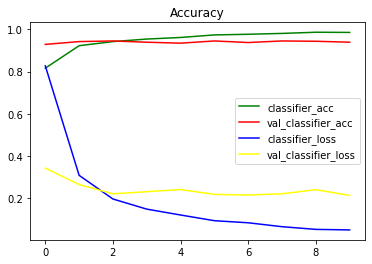

In [28]:
pyplot.plot(history.history['cl_cancer_acc'], color = 'green', label = 'classifier_acc')
pyplot.xlabel="epoch"
pyplot.plot(history.history['val_cl_cancer_acc'], color = 'red', label = "val_classifier_acc")

pyplot.plot(history.history['cl_cancer_loss'], color = 'Blue', label = "classifier_loss")
pyplot.plot(history.history['val_cl_cancer_loss'], color = 'yellow', label = "val_classifier_loss")

pyplot.title('Accuracy')
pyplot.legend()
pyplot.savefig("plot_acc.png")

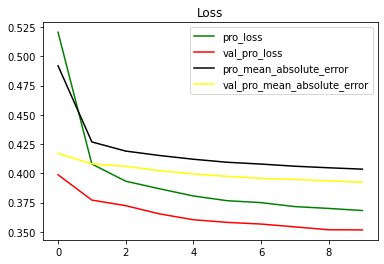

In [29]:
pyplot.plot(history.history['pro_loss'], color = 'green', label = 'pro_loss')
pyplot.xlabel="epoch"
pyplot.plot(history.history['val_pro_loss'], color = 'red', label = "val_pro_loss")
pyplot.plot(history.history['pro_mean_absolute_error'], color = 'black', label = 'pro_mean_absolute_error')
pyplot.plot(history.history['val_pro_mean_absolute_error'], color = 'yellow', label = 'val_pro_mean_absolute_error')
pyplot.title('Loss')
pyplot.legend()
pyplot.savefig("plot_loss.png")